# Affine transforms
This notebook demonstrates how to apply affine transforms to 3D images.

In [1]:
import pyclesperanto_prototype as cle

cle.select_device('RTX')

<NVIDIA GeForce RTX 3080 on Platform: NVIDIA CUDA (1 refs)>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from skimage.io import imshow
import pyclesperanto_prototype as cle
# Helper function for reading ImageJs ZIP file examples
import requests
import zipfile
from io import BytesIO
from tifffile import imread
import math

def remote_reader(url):
    """generator that returns the first numpy arrays representing 
    in a tif in a remote zip."""
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(BytesIO(response.content)) as zf:
        for path in zf.filelist:
            with zf.open(path, "r") as f:
                # f is a file-like object of type zipfile.ZipExtFile
                # replace imread with any file-reader of your choice
                # that accepts a file-like object as input 
                return imread(f)

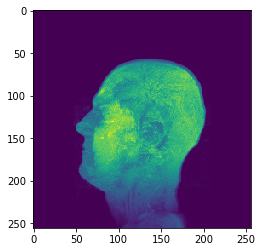

In [3]:
# push it to GPU memory
np_array = remote_reader('https://imagej.nih.gov/ij/images/t1-head.zip')

input_image = cle.push(np_array)

cle.imshow(input_image)

### Shearing



#### Current API

This is the current implementation in pyclesperanto

In [4]:
#This is the current form of the shear in Z plane matrix
#I've modified it so we can use it within this notebook

def shear_in_z(angle_x_in_degrees: float = 0, angle_y_in_degrees: float = 0 ):
    """Shear image in Z-plane along X and/or Y direction
       Uses angle in degrees to calculate the shear
       Tip: Used for lattice lightsheet deskewing. For Janelia lattice, use angle_x_in_degrees and for Zeiss lattice, use angle_y_in_degrees

    Args:
        angle_x_in_degrees (float, optional): shear angle in X in degrees. Defaults to 0.
        angle_y_in_degrees (float, optional): shear angle in Y in degrees. Defaults to 0.
                angle in degrees. To convert radians to degrees use this formula:
                angle_in_deg = angle_in_rad / numpy.pi * 180.0

    Returns:
        self
    """          
    import math
    try:
        shear_factor_xz = 1.0 / math.tan((angle_x_in_degrees-90) * math.pi / 180)
    except ZeroDivisionError:
        print("Error1")
        shear_factor_xz = math.pi
            
    try:
        shear_factor_yz = 1.0 / math.tan((angle_y_in_degrees-90) * math.pi / 180)
    except ZeroDivisionError:
        print("Error2")
        shear_factor_yz = math.pi
    mat = cle.AffineTransform3D()._matrix
    mat1 = (np.asarray([
        [1, shear_factor_xz, 0, 0],
        [shear_factor_yz, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]))
    return np.matmul(mat, mat1)

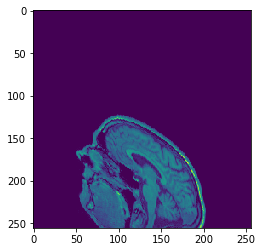

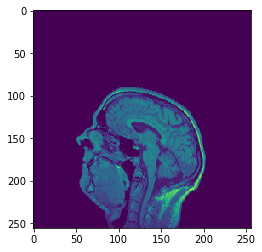

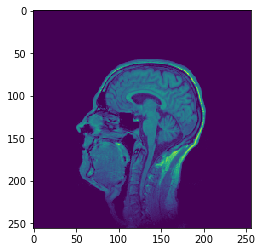

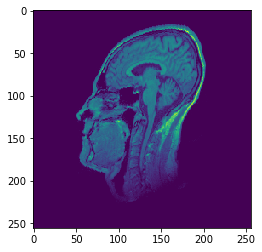

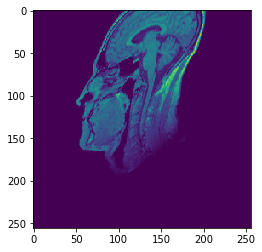

Error2


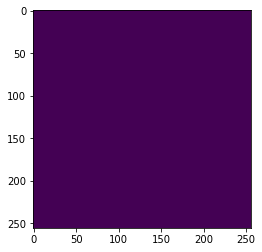

In [5]:
#For example, to shear the image in the Y axis along YZ plane using a shear angle of 30 degrees

for shear_angle in [-30, -15, 0, 15, 30, 90]:
    #transform = cle.AffineTransform3D()
    shear_transform= shear_in_z(angle_y_in_degrees=shear_angle)

    transformed_image = cle.affine_transform(input_image, transform=shear_transform)
    cle.imshow(transformed_image[64])


#### Shear matrix for shear in Z plane either for X and Y direction
Matrix in the current clesperanto API

$\begin{bmatrix} 1,h_{xz},0,0 \\ h_{yz},1,0,0 \\ 0,0,1,0 \\ 0,0,0,1 \end{bmatrix}$

but, based on my testing, the matrix for xyz is the one that works:

$\begin{bmatrix} 1,0,h_{xz},0 \\ 0,1,h_{yz},0 \\ 0,0,1,0 \\ 0,0,0,1 \end{bmatrix}$

This is based on my understanding from deskewing a lattice dataset as well

#### Calculating shear factor:

These are the two possible equations I've been using and that work for me

math.tan((90-angle_x_in_degrees) * math.pi / 180)

OR

1/math.tan((angle_x_in_degrees) * math.pi / 180)

Also, whether you use (90-angle) or (angle-90) matters as the sign of the shear factor determines the direction of shear in Y

In [9]:

def shear_in_z(angle_x_in_degrees: float = 0, angle_y_in_degrees: float = 0 ):
    """Shear image in Z-plane along X and/or Y direction
       Uses angle in degrees to calculate the shear
       Tip: Used for lattice lightsheet deskewing. For Janelia lattice, use angle_x_in_degrees and for Zeiss lattice, use angle_y_in_degrees

    Args:
        angle_x_in_degrees (float, optional): shear angle in X in degrees. Defaults to 0.
        angle_y_in_degrees (float, optional): shear angle in Y in degrees. Defaults to 0.
                angle in degrees. To convert radians to degrees use this formula:
                angle_in_deg = angle_in_rad / numpy.pi * 180.0

    Returns:
        self
    """          
    import math
    
    try:
        shear_factor_xz = 1/math.tan((angle_x_in_degrees) * math.pi / 180)
    except ZeroDivisionError:
        print("Error1")
        shear_factor_xz = 0
            
    try:
        shear_factor_yz = 1/math.tan((angle_y_in_degrees) * math.pi / 180)
    except ZeroDivisionError:
        print("Error2")
        shear_factor_yz = 0
    mat = cle.AffineTransform3D()._matrix
    mat1 = (np.asarray([
        [1, 0, shear_factor_xz, 0],
        [0, 1, shear_factor_yz, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1],
    ]))
    #print(mat1)
    return np.matmul(mat, mat1)


Error1
-45


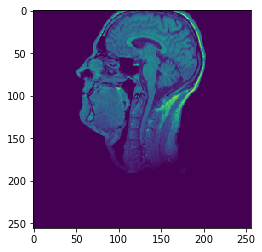

Error1
Error2
0


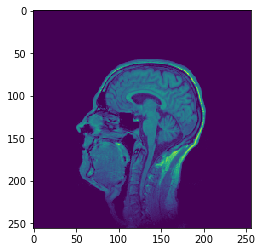

Error1
45


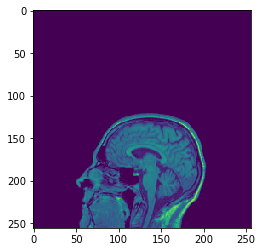

Error1
90


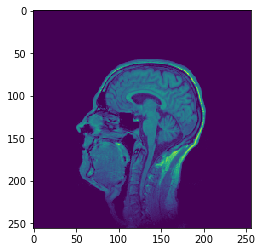

In [11]:
#For example, to shear the image in the Y axis along YZ plane using a shear angle of 30 degrees

for shear_angle in [-45,  0, 45, 90]:
    #transform = cle.AffineTransform3D()
    shear_transform= shear_in_z(angle_y_in_degrees=shear_angle)

    transformed_image = cle.affine_transform(input_image, transform=shear_transform)
    print(shear_angle)
    cle.imshow(transformed_image[64])

### Testing on lattice data

I have tested this on a lattice data, where shear angle is 30 degree in the Y-direction

In [7]:
def remote_reader_tiff(url):
    """generator that returns the first numpy arrays representing 
    a tif from remote tif."""
    response = requests.get(url)
    response.raise_for_status()
    tiff_file =  BytesIO(response.content)
    return imread(tiff_file)

rbc_data = remote_reader_tiff('http://cloudstor.aarnet.edu.au/plus/s/eAy7Wypjkt3IjtN/download')
rbc_data.shape



(834, 118, 209)

Error1
-30


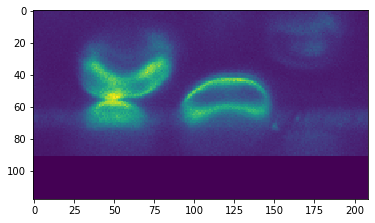

Error1
Error2
0


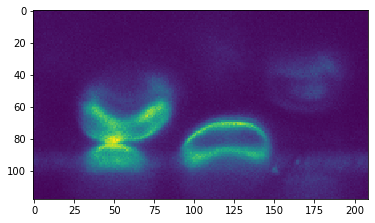

Error1
30


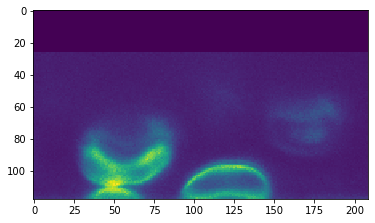

In [12]:
#For example, to shear the image in the Y axis along YZ plane using a shear angle of 30 degrees

for shear_angle in [-30,  0, 30]:
    #transform = cle.AffineTransform3D()
    shear_transform= shear_in_z(angle_y_in_degrees=shear_angle)

    transformed_image = cle.affine_transform(rbc_data, transform=shear_transform)
    print(shear_angle)
    cle.imshow(transformed_image[15])

In [13]:
shear_in_z(angle_y_in_degrees=30)

Error1


array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 1.73205081, 0.        ],
       [0.        , 0.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 1.        ]])